In [1]:
!pwd

/home/analytics/Memelysis/analytics


In [2]:
import findspark
findspark.init()

In [8]:
import subprocess

from pyspark import SparkContext, SparkConf
import re
from pyspark.sql.types import StructType, IntegerType, StringType, FloatType
from pyspark.sql import SparkSession, SQLContext, functions

from pyspark.sql.functions import lit
from functools import reduce
from pyspark.sql import DataFrame

In [4]:
sc = SparkContext.getOrCreate()
spark = SparkSession.builder.getOrCreate()

In [5]:
cmd = 'hdfs dfs -ls /jsons/'

files = subprocess.check_output(cmd, shell=True)
files = files.strip()
files = files.decode().split('\n')

out = []

for path in files:
    f = path.split(" ")[-1]
    if 'memes_' in f:
        out.append(f)
        print(f)

/jsons/memes_1588956783893.json
/jsons/memes_1588975800125.json
/jsons/memes_1588979400070.json
/jsons/memes_1588983000044.json
/jsons/memes_1588986600066.json
/jsons/memes_1588990200082.json
/jsons/memes_1588993800056.json
/jsons/memes_1588997400057.json
/jsons/memes_1589001000045.json
/jsons/memes_1589004600051.json
/jsons/memes_1589008200048.json
/jsons/memes_1589011800040.json
/jsons/memes_1589015400180.json
/jsons/memes_1589019000033.json
/jsons/memes_1589022600061.json
/jsons/memes_1589026200044.json
/jsons/memes_1589029800040.json
/jsons/memes_1589033400043.json
/jsons/memes_1589040600208.json
/jsons/memes_1589041500031.json
/jsons/memes_1589045100027.json
/jsons/memes_1589048700046.json
/jsons/memes_1589052300046.json
/jsons/memes_1589055900052.json
/jsons/memes_1589059500050.json
/jsons/memes_1589063100032.json
/jsons/memes_1589066700055.json
/jsons/memes_1589070300062.json
/jsons/memes_1589073900056.json
/jsons/memes_1589077500054.json
/jsons/memes_1589081100053.json
/jsons/m

In [6]:
sqlContext = SQLContext(sc)

In [9]:
freq = {}
for path in out:
    print(path)
    df = spark.read.json(path)
    source = df.groupby('source').count().toPandas().set_index('source').T.to_dict('list')
    timestamp = re.findall(r'\d+', path)[0]
    freq[timestamp] = source
    print(timestamp)
    print(source)

/jsons/memes_1588956783893.json
1588956783893
{'reddit': [325]}
/jsons/memes_1588975800125.json
1588975800125
{'imgur': [6], 'twitter': [38], 'reddit': [227], 'memedroid': [51]}
/jsons/memes_1588979400070.json
1588979400070
{'twitter': [73], 'reddit': [259], 'memedroid': [6]}
/jsons/memes_1588983000044.json
1588983000044
{'twitter': [52], 'reddit': [215], 'memedroid': [7]}
/jsons/memes_1588986600066.json
1588986600066
{'imgur': [12], 'twitter': [33], 'reddit': [257], 'memedroid': [6]}
/jsons/memes_1588990200082.json
1588990200082
{'imgur': [36], 'twitter': [50], 'reddit': [211], 'memedroid': [20]}
/jsons/memes_1588993800056.json
1588993800056
{'imgur': [30], 'twitter': [23], 'reddit': [224], 'memedroid': [17]}
/jsons/memes_1588997400057.json
1588997400057
{'imgur': [14], 'twitter': [29], 'reddit': [180], 'memedroid': [12]}
/jsons/memes_1589001000045.json
1589001000045
{'imgur': [10], 'twitter': [28], 'reddit': [181], 'memedroid': [8]}
/jsons/memes_1589004600051.json
1589004600051
{'img

In [10]:
freq1 = []
for k, v in freq.items():
    row = [k]
    for source in ['twitter', 'reddit', 'imgur', 'memedroid']:
        try:
            row.append(v[source][0])
        except KeyError:
            row.append(0)
    freq1.append(row)
        

In [11]:
import pandas as pd
from datetime import datetime

data = pd.DataFrame(freq1, columns = ['timestamp', 'twitter', 'reddit', 'imgur', 'memedroid'])
data.timestamp = data.timestamp.astype(int)

In [12]:
data['timestamp_str']  = data.timestamp.apply(lambda x: datetime.fromtimestamp(int(x)/1e3))
data = data.sort_values('timestamp').reset_index()

In [13]:
import matplotlib.pyplot as plt

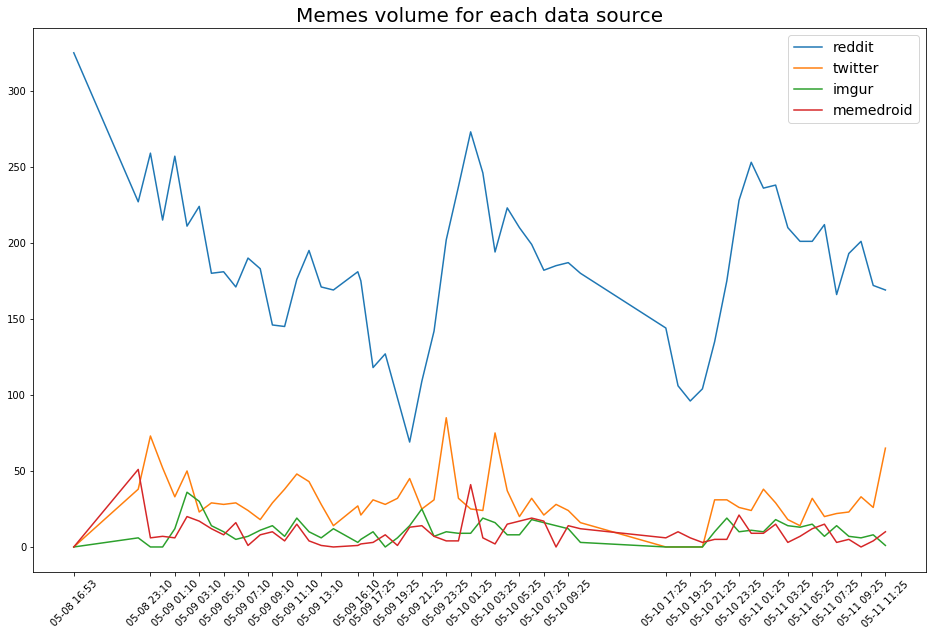

In [35]:
plt.figure(figsize=(16,10))
plt.plot(data.timestamp, data.reddit, label = 'reddit')
plt.plot(data.timestamp, data.twitter, label = 'twitter')
plt.plot(data.timestamp, data.imgur, label = 'imgur')
plt.plot(data.timestamp, data.memedroid, label = 'memedroid')

plt.legend(loc='upper right', fontsize=14)
plt.title("Memes volume for each data source", fontsize=20)
plt.xticks(rotation=45)
plt.xticks(data.timestamp[::2], data.timestamp_str.apply(lambda x:  str(x)[5:-10])[::2])

plt.show()

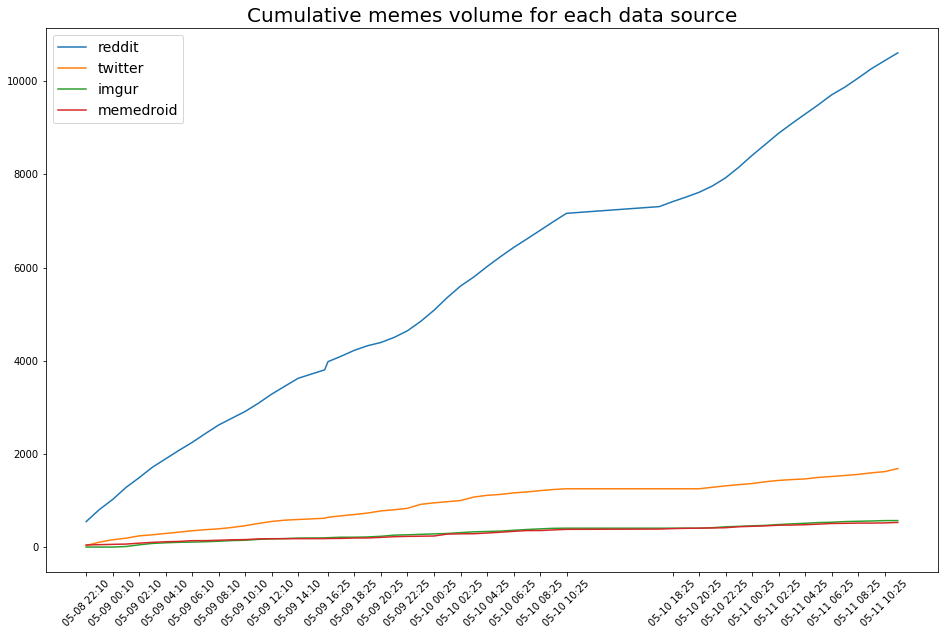

In [36]:
cumsum = pd.DataFrame({'timestamp':data.timestamp[1:],
                      'timestamp_str': data.timestamp_str[1:],
                      'reddit': data.reddit.cumsum(),
                      'twitter': data.twitter.cumsum(),
                      'imgur': data.imgur.cumsum(),
                      'memedroid': data.memedroid.cumsum()})
cumsum = cumsum.loc[1:, :]
plt.figure(figsize=(16,10))
plt.plot(cumsum.timestamp, cumsum.reddit, label = 'reddit')
plt.plot(cumsum.timestamp, cumsum.twitter, label = 'twitter')
plt.plot(cumsum.timestamp, cumsum.imgur, label = 'imgur')
plt.plot(cumsum.timestamp, cumsum.memedroid, label = 'memedroid')

plt.legend(loc='upper left', fontsize=14)
plt.title("Cumulative memes volume for each data source", fontsize=20)
plt.xticks(rotation=45)
plt.xticks(cumsum.timestamp[::2], cumsum.timestamp_str.apply(lambda x:  str(x)[5:-10])[::2])

plt.show()

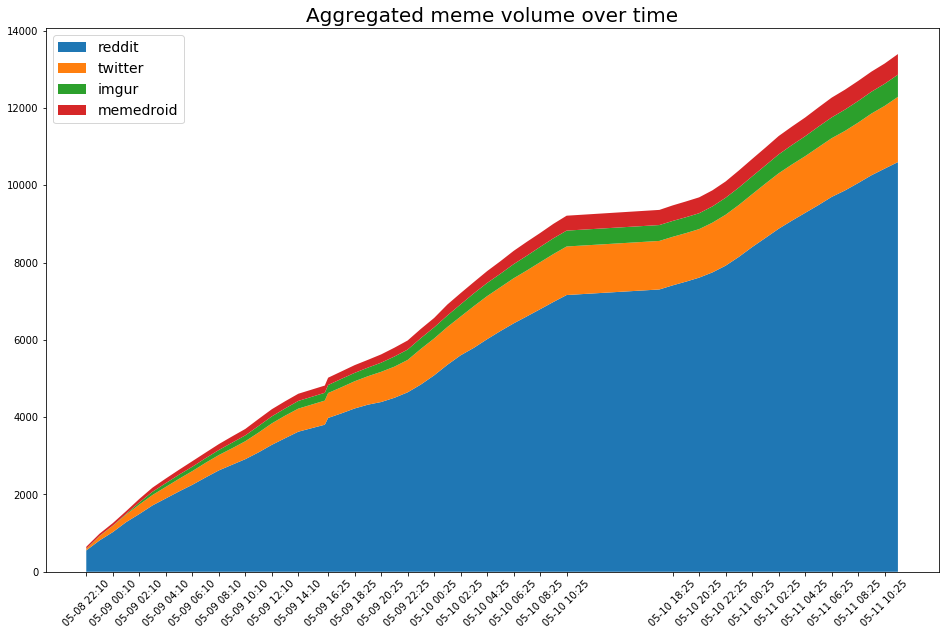

In [37]:
plt.figure(figsize=(16,10))
plt.stackplot(cumsum.timestamp,
              [cumsum.loc[:, source] for source in ['reddit', 'twitter', 'imgur', 'memedroid']],
             labels=['reddit', 'twitter', 'imgur', 'memedroid'])


plt.legend(loc='upper left', fontsize=14)
plt.title("Aggregated meme volume over time", fontsize=20)
plt.xticks(rotation=45)
plt.xticks(cumsum.timestamp[::2], cumsum.timestamp_str.apply(lambda x:  str(x)[5:-10])[::2])

plt.show()